---

<h1>DataScientest.com : Formation Data Scientist </h1>

---
*   **CURSUS :** Bootcamp DS, Juillet 2021
*   **PROJET 04 :**  ÉNERGIE - (MACHINE LEARNING)
*   **STEP 1 :**  Élaboration d’un modèle et premières itérations.
*  **CHEF DE PROJET :** Mounir
*   **PARTICIPANTS :** Romain MOULY & Zéphirin NGANMENI
---



<h1>Preprocessing des données</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eco2mix-regional-cons-def.csv', sep=';');

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#drop des colonnes vides ou quasiment vides (les TCO sont les taux de couverture par filière, les flux sont incomplets, le TCH est inconnu)

filter_col2 = [col for col in df if col.startswith('TCH')]
filter_col3 = [col for col in df if col.startswith('Flux')]
filter_col = filter_col2 + filter_col3

df = df.drop(filter_col,axis=1)

#drop des colonnes inutiles (techniques)
df = df.drop(['Nature', 'Code INSEE région'],axis=1)

In [4]:
#drop des lignes sans data de consommation ou production
float_list = list(df.select_dtypes('float64').columns)
df = df.dropna(subset=float_list, how='all', axis=0)

#remplissage des NA par des 0 sur les colonnes de consommation et production
for column in float_list:
    df[column].fillna(0, inplace=True)
    
#remplissage des NAN des colonnes de taux de couverture de la consommation par le calcul correspondant
df['TCO Thermique (%)'].fillna((df['Thermique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Nucléaire (%)'].fillna((df['Nucléaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Eolien (%)'].fillna((df['Eolien (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Solaire (%)'].fillna((df['Solaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Hydraulique (%)'].fillna((df['Hydraulique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Bioénergies (%)'].fillna((df['Bioénergies (MW)'] / df['Consommation (MW)']*100), inplace=True)

In [5]:
#feature engineering (création de colonnes agrégées)

df['Renouvelables (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Pompage (MW)']
df['Solde brut (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] - df['Consommation (MW)']
df['Solde avec transferts (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] + df['Ech. physiques (MW)'] - df['Consommation (MW)']
#remarque sur le pompage: uniquement des valeurs négatives donc représente la consommation d'électricité pour alimenter les pompes des stations de transfert d'énergie (STEP). La production doit alors être classifiée dans l'hydraulique.


#Taux de couvetures de la consommation

df['Taux Couverture (MW)'] = (df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)']) / df['Consommation (MW)']
df['Taux Couverture Renouvelables (MW)'] = df['Renouvelables (MW)'] / df['Consommation (MW)']

In [6]:
#Mise au format date et extraction des éléments de la date en tant que colonnes
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
df['Jour'] = df['Date'].dt.day
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = pd.PeriodIndex(df['Date'], freq='Q').astype('string') # alternative: ((x.month-1)//3) +1
df['Année'] = df['Date'].dt.year
df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.time #alternative: format='%H:%M:%S'
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], utc=True)

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
count,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00
mean,4499.02,373.95,3678.17,246.14,86.14,608.51,-65.87,81.66,-510.03,1.33,15.09,1.66,0.54,2.12,0.39,956.58,509.67,-0.36,1.22,0.20,3.00,15.72,6.35,2016.76
std,2173.38,537.57,3876.44,412.40,209.85,1040.19,243.05,44.55,4372.91,4.72,56.66,6.26,3.03,8.60,0.90,1117.32,4372.87,5.63,1.23,0.18,2.00,8.80,3.45,2.46
min,895.00,-83.00,-144.00,-6.00,-23.00,-14.00,-2570.00,4.00,-12219.00,-2.54,-2.98,-0.10,-0.08,-1.06,0.00,-1280.00,-13960.00,-704.00,-0.18,-0.24,0.00,1.00,1.00,2013.00
25%,2789.00,24.00,0.00,26.00,0.00,5.00,-1.00,46.00,-4264.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,-2229.00,-1.00,0.20,0.06,1.00,8.00,3.00,2015.00
50%,4111.00,153.00,2583.00,101.00,0.00,57.00,0.00,72.00,473.00,0.00,0.00,0.00,0.00,0.00,0.00,471.00,-473.00,0.00,0.90,0.14,3.00,16.00,6.00,2017.00
75%,5741.00,480.00,6845.00,289.00,63.00,897.00,0.00,114.00,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,1370.00,4264.00,0.00,1.86,0.29,5.00,23.00,9.00,2019.00
max,15338.00,4293.00,13632.00,4554.00,2392.00,8742.00,0.00,404.00,13959.00,56.89,787.27,100.50,59.47,115.57,7.33,9120.00,12218.00,700.00,8.09,1.31,6.00,31.00,12.00,2021.00


<h1> Clustering  </h1>

A partir des différentes séries chronologiques par régions issues de la consommation totale et des consommations des différents types d'énergies, nous allons proposer un regroupement en groupes similaires. Pour simplifier la tache, nous allons utiliser les moyennes des consommations mensuelles. 

Nous proposons un graphe avec plusieurs onglets. Le premier onglet porte sur la consommation totale et chacun des autres onglets porte porte sur la consommation d'une catégorie d'énergie. Dans chaque cas, nous classons les régions dans l'ordre décroissant de la consommation totale. Ainsi les régions avec de grandes consommations sont classées en premières possitions et les régions avec de faibles consommations son classées en dernières positions. 

La variable Data est un dictionnaire dont les clés sont des types d'énergie et les valeurs sont des tableaux de valeurs, chaque ligne de chaque tableau représente une série pour une région donnée. 

<h2> Choix de la métrique </h2>
Nous utilisons la métrique de déformation temporelle dynamique, en anglais Dynamic Time Warping (DTW). Cette métrique est plus appropriée pour l'étude des séries temporelles. Pour déterminer le nombre optimal de classes, nous utilisons la méthode du coude qui est l’une des méthodes les plus populaires. Nous constatons que ce nombre optimal est de 3 pour les différents cas qui nous intéressent. Nous utilisons trois familles de couleurs(bleue, rouge, verte) pour distinguer les séries d'une même classe. 

In [9]:
df_z1 = df.copy() #une copie de la dataframe. 
df_z1['Date']=df_z1['Date'].apply(lambda x : str(x)[:7]) #On considère année-mois 

In [10]:
types = ['Consommation (MW)','Thermique (MW)','Nucléaire (MW)','Eolien (MW)','Solaire (MW)','Hydraulique (MW)', 'Bioénergies (MW)']
regions =[]
for i in range(7):
  df_ztemp = df_z1.groupby(['Région'])[types[i]].sum().reset_index().sort_values(by=types[i], ascending=False)
  regions.append (df_ztemp['Région'].unique().tolist())
df_z1 = df_z1.groupby(['Région','Date']).aggregate({'Consommation (MW)': 'mean', 
                                                    'Thermique (MW)': 'mean',
                                                    'Nucléaire (MW)': 'mean',
                                                    'Eolien (MW)': 'mean',
                                                    'Solaire (MW)': 'mean',
                                                    'Hydraulique (MW)': 'mean',
                                                    'Bioénergies (MW)': 'mean' }).reset_index()


In [ ]:
%%bash
pip install tslearn 

In [15]:
from bokeh.plotting import figure
import numpy as np
import matplotlib.pyplot as plt
import random
from bokeh.models.widgets import Panel, Tabs  
from bokeh.plotting import output_notebook, show
from tslearn.clustering import TimeSeriesKMeans
output_notebook()
tab = []
data = {}
c=[]
c.append(['#191970', '#000080', '#00008B', '#0000CD', '#0000FF', '#4169E1', '#4682B4', '#6495ED', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6'])
c.append(['#800000', '#A52A2A', '#A0522D', '#8B4513', '#D2691E', '#CD853F', '#B8860B', '#DAA520', '#F4A460', '#D2B48C', '#F5DEB3', '#FFEBCD'])
c.append(['#006400', '#008000', '#228B22', '#2E8B57', '#66CDAA', '#8FBC8F', '#98FB98', '#90EE90', '#ADFF2F', '#7FFF00', '#00FF00', '#32CD32'])
for i in range(7):
  s =[]
  for j in range(12):
    s.append(np.array(df_z1[df_z1['Région']==regions[i][j]][types[i]]))
  data[types[i]] = s.copy()

for i in range(7):
  p = figure(plot_width = 800, plot_height = 350, title = "Consommation moyenne en MW, par type d'énergie, par an et par région.")
  model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
  prediction = model.fit_predict(data[types[i]])
  for j in range(12):
    p.line(x=np.arange(len(data[types[i]][j])), y = data[types[i]][j], line_width=2, color = c[prediction[j]][j],  alpha=1, legend_label=regions[i][j])
  p.add_layout(p.legend[0], 'right')
  tab.append(Panel(child = p, title = types[i][:-5]))
show(Tabs(tabs = tab))


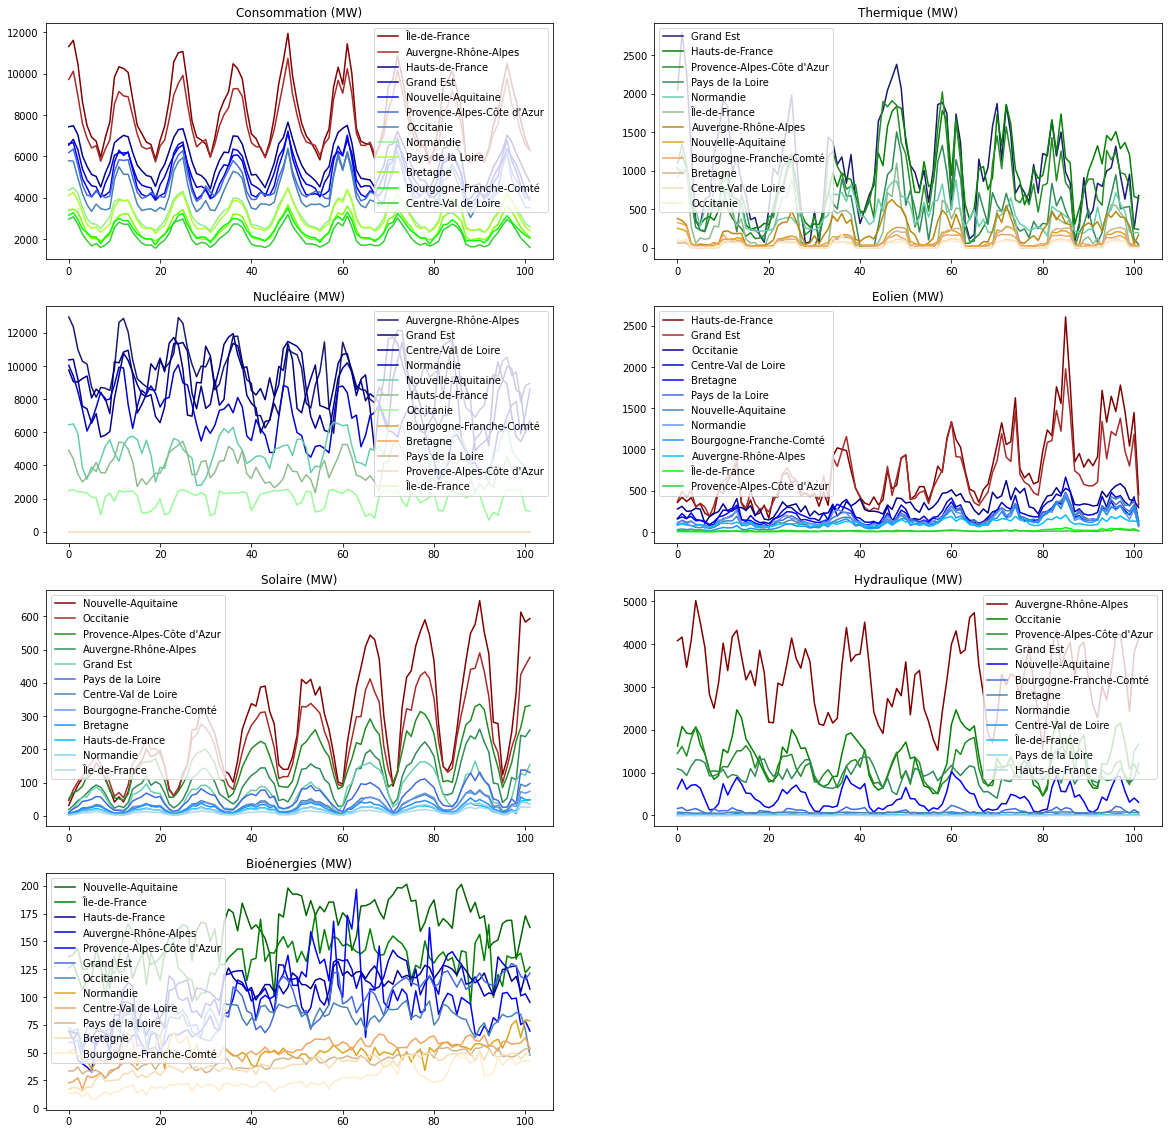

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tslearn.clustering import TimeSeriesKMeans
tab = []
data = {}
c=[]
c.append(['#191970', '#000080', '#00008B', '#0000CD', '#0000FF', '#4169E1', '#4682B4', '#6495ED', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6'])
c.append(['#800000', '#A52A2A', '#A0522D', '#8B4513', '#D2691E', '#CD853F', '#B8860B', '#DAA520', '#F4A460', '#D2B48C', '#F5DEB3', '#FFEBCD'])
c.append(['#006400', '#008000', '#228B22', '#2E8B57', '#66CDAA', '#8FBC8F', '#98FB98', '#90EE90', '#ADFF2F', '#7FFF00', '#00FF00', '#32CD32'])
for i in range(7):
  s =[]
  for j in range(12):
    s.append(np.array(df_z1[df_z1['Région']==regions[i][j]][types[i]]))
  data[types[i]] = s.copy()

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(1,8):
  ax = fig.add_subplot(4, 2, i)
  ax.set_title(types[i-1])
  model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
  prediction = model.fit_predict(data[types[i-1]])
  for j in range(12):
    ax.plot(np.arange(len(data[types[i-1]][j])), data[types[i-1]][j], color = c[prediction[j]][j],  alpha=1, label=regions[i-1][j])
    ax.legend()



<h1> Regroupement hiérarchique (Hierarchical clustering) </h1>

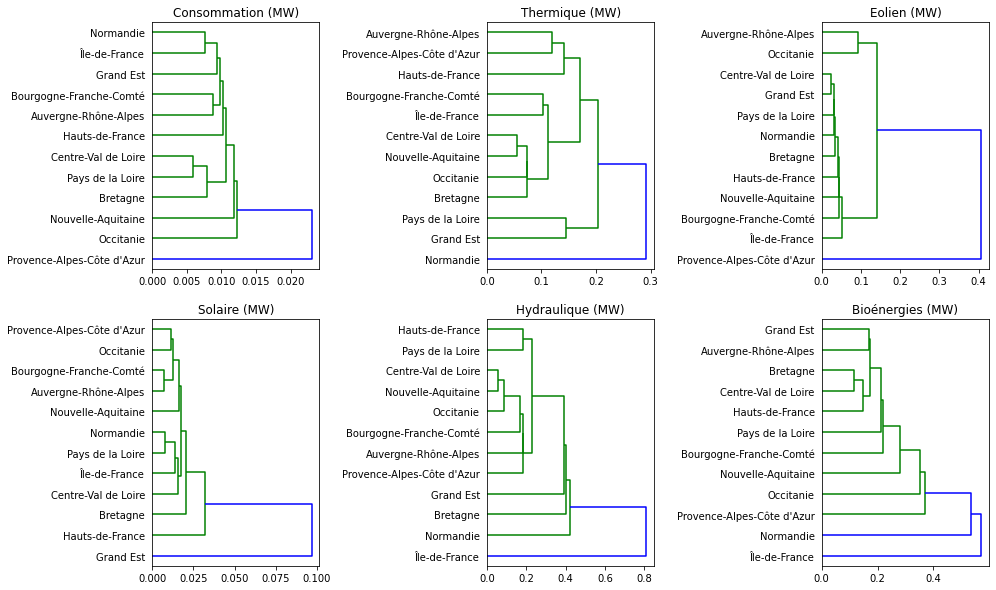

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as hac
from scipy import stats

def ma_distance(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r 

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.2, wspace=1)
for t in range(1,7): 
  ax = fig.add_subplot(2, 3, t)
  if t > 2 : 
    t = t+1
  ax.set_title(types[t-1])
  Z = hac.linkage(data[types[t-1]], method='single', metric=ma_distance)
  hac.dendrogram(
      Z,
      labels=regions[t-1],
      orientation='right',
      leaf_font_size=10., 
  )

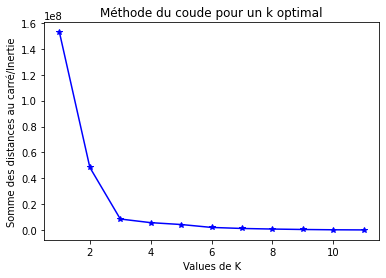

In [80]:
#Vérification nombre optimale de classes. 
from tslearn.clustering import TimeSeriesKMeans
t=0 #De 0 à 6 pour les types d'énergie
somme_dis_car = []
K = range(1,12)
for i in K :
 tkmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw")
 tkmeans.fit(data[types[t]])
 somme_dis_car.append(tkmeans.inertia_)
plt.plot(K,somme_dis_car,'b*-')
plt.xlabel('Values de K') 
plt.ylabel('Somme des distances au carré/Inertie') 
plt.title('Méthode du coude pour un k optimal')
plt.show()

In [164]:
#Exemple de classification
from tslearn.clustering import TimeSeriesKMeans
t=0 #De 0 à 6 pour les types d'énergie
# On choisit la distance DTW et on fixe 'k' à 2
model = TimeSeriesKMeans(n_clusters=3, metric="dtw")
prediction = model.fit_predict(data[types[t]])
print(prediction);

[1 1 2 2 2 2 2 0 0 0 0 0]
